## Generating a Toy Dataset from the LIDC-IDRI CT scans

To be able to test wether our MaskRCNN works properly, we need a ToyDataset, that is surely an easy enough job for the NN. 
We need a dataset with which we can test:
- classification
- segmentation
- bounding box generation

For this we generate a dataset of 2D CT slices containing heart or star shaped masks. 

In [1]:
import cv2
import numpy as np
import os
from PIL import Image
import nrrd
import random
import json
import re
import pylidc as pl
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
ctpath='./cts'#define the path to the CT slices
normalizedctpath='./normalized_cts'#define the path to the normalized CTs
toydatasetpath='./toydataset'#define the path to the toydataset

First we choose some CT slices. For this you need to download the LIDC dataset, and have a configfile, as follows:
- On Windows, the file should be located at C:Users[User]pylidc.conf
- On Linux and Mac, the file should be located at /home/[user]/.pylidcrc

The config file has to contain the path to the LIDC-IDRI dataset, looking like this:

[dicom]\
path = /path/to/big_external_drive/datasets/LIDC-IDRI

In [12]:
#Download CT slices from the LIDC-IDRI dataset. This function downloads slices based on the annotation/nodule malignancy score
def getMalignancyByScore(score):
    anns = pl.query(pl.Annotation).filter(pl.Annotation.malignancy == score)
    n=0
    for a in anns:
        scan=pl.query(pl.Scan).filter(pl.Scan.id == a.scan_id).first()
        scan=scan.to_volume()
        for i in a.contour_slice_indices:
            scanslice=scan[:,:,i]
            n+=1
            if n==5000:
                return
            filepath=os.path.join(ctpath,str(n))
            np.save(filepath,scanslice)

In [13]:
getMalignancyByScore(5)


Loading dicom files ... This may take a moment.


In [3]:
#CT slice values can be very high/low with outstanding values. Lets normalize them to the range 0-255
numoffiles=len(os.listdir(ctpath))
allcts=np.zeros((numoffiles,512,512))
for num,file in enumerate(os.listdir(ctpath)):
    im=np.load(os.path.join(ctpath,file))
    
    avg=np.mean(im)
    std=np.std(im)
    im=(im-avg)/std
    immin=np.amin(im)
    im=im-immin
    immax=np.amax(im)
    im=im/immax
    im=im*255
    allcts[num]=im
    

In [4]:
#Lets save the normalized CTs
for num, im in enumerate(allcts):
    filename=str(num).zfill(6)+'.npy'
    file=os.path.join(normalizedctpath,filename)
    np.save(file,im)

In [5]:
#Lets load our masks
masks=np.zeros([2,65,65],dtype=np.float32)
maskfolder='./masks'
for num,file in enumerate(os.listdir(maskfolder)):
    img=Image.open(os.path.join(maskfolder,file))
    data = np.array(img, dtype='float32' )
    masks[num]=data[:,:,0]

print(masks.shape)
maskx=masks[0].shape[0]
masky=masks[0].shape[1]

masks=(masks/255)
print(np.amin(masks),np.amax(masks),np.amin(masks),np.amax(masks))


(2, 65, 65)
0.0 1.0 0.0 1.0


## generate a JSON file

First we generate a json file, which randomly choses mask to the CTslice. The possibilities are: 
- nothing
- star
- heart
- heart and star
,it also generates a placement to them (xmin, ymin), and a random resize factor (factor 0.6-1).
It will contain the bbox coordinates as well (xmin,ymin,xmax,ymax).

We will generate our toydataset from this json.

The file will look as:
dictionary{filename: dictionary2} in the dictionary the keys are the filenames, the values are dictionaries, containing the informations about the file

In [6]:
folder_in=ctpath
numoffiles=len(os.listdir(ctpath))
datasetInfo={}

for num in range(numoffiles):  
    rx=random.randint(150,350)
    ry=random.randint(150,350)
    rm=random.randint(0,3)
    rf=random.randint(6,10)/10
    ns=round(rf*maskx)

    if rm == 0:
        rm=[1,0]
        x1=rx
        x2=rx+ns
        y1=ry
        y2=ry+ns
        bbox=[[x1,y1,x2,y2]]
        
        datasetInfo[str(num).zfill(6)+'.nrrd']={'label': rm,'xmin':rx,'ymin': ry,'factor': rf , 'size': ns,'bbox':bbox}
    elif rm == 1:
        rm=[0,1]
        
        x1=rx
        x2=rx+ns
        y1=ry
        y2=ry+ns
        bbox=[[x1,y1,x2,y2]]
        
        
        datasetInfo[str(num).zfill(6)+'.nrrd']={'label': rm,'xmin':rx,'ymin': ry,'factor': rf , 'size': ns,'bbox':bbox}
    elif rm==3:
        rm=[1,1]
        rx2=random.randint(150,300)
        ry2=random.randint(150,300)
        rf2=random.randint(3,10)/10
        ns2=round(rf2*maskx)
        
        x11=rx
        x21=rx+ns
        y11=ry
        y21=ry+ns
        
        bbox1=[x11,y11,x21,y21]
        
        x12=rx2
        x22=rx2+ns2
        y12=ry2
        y22=ry2+ns2
        
        bbox2=[x12,y12,x22,y22]
        bbox=[bbox1,bbox2]
        
        rx=[rx,rx2]
        ry=[ry,ry2]
        rf=[rf,rf2]
        ns=[ns,ns2]
    
        datasetInfo[str(num).zfill(6)+'.nrrd']={'label': rm,'xmin':rx, 'ymin': ry, 'factor': rf, 'size': ns,'bbox':bbox }
    else:
        rm=[0,0]
        datasetInfo[str(num).zfill(6)+'.nrrd']={'label': rm,'xmin':0,'ymin': 0,'factor': 0 ,'size': 0,'bbox':[[0,0,0,0]]}
        

with open(os.path.join(toydatasetpath,'dataInfo.json'), 'w') as f:
    json_object = json.dump(datasetInfo,f)   


Generate toydataset from the json file. We will also modify the json file, as we calculate the contrast for each mask, and save that to the jsonfile.


In [8]:
pernum=5
folder_in=normalizedctpath
dataFolder=os.path.join(toydatasetpath,'images')
maskFolder=os.path.join(toydatasetpath,'masks')

with open(os.path.join(toydatasetpath,'dataInfo.json')) as j:
     dataInfo_ = json.loads(j.read())
        
totalMask=np.zeros((512,512))
for file in dataInfo_.keys():
    #read in the proper npy file
    npfile=re.findall('\d+', file )[0]+'.npy'
    im=np.squeeze(np.load(os.path.join(folder_in,npfile)))
    im=(np.array(im,dtype=np.float32))
    maskfile=np.copy(totalMask)
    immax=np.amax(im)
    
    label=dataInfo_[file]['label']
    
    if label==[1,1]:
        
        f0=dataInfo_[file]['factor'][0]
        f1=dataInfo_[file]['factor'][1]

        x0=dataInfo_[file]['xmin'][0]
        x1=dataInfo_[file]['xmin'][1]
        
        y0=dataInfo_[file]['ymin'][0]
        y1=dataInfo_[file]['ymin'][1]
        
        newsize0 = (round(maskx*f0),round(masky*f0))
        ns0=newsize0[0]
        newsize1 = (round(maskx*f1),round(masky*f1))
        ns1=newsize1[0]

        mask0 = cv2.resize(np.copy(masks[0]),(newsize0))*immax/pernum
        mask1 = cv2.resize(np.copy(masks[1]),(newsize1))*immax/pernum

        origsquare0=np.copy(im[x0:x0+ns0,y0:y0+ns0])
        
        im[x0:x0+ns0,y0:y0+ns0]=im[x0:x0+ns0,y0:y0+ns0]+mask0
        maskfile[x0:x0+ns0,y0:y0+ns0]=maskfile[x0:x0+ns0,y0:y0+ns0]+mask0*100
        newimmax0=np.amax(im)
        im[im>immax]=immax
        maskfile[maskfile>0.5]=1
        
        maskedsquare0=np.copy(im[x0:x0+ns0,y0:y0+ns0])
        
        maskintensity=np.mean(maskedsquare0[maskedsquare0!=origsquare0])
        backgroundintensity=np.mean(maskedsquare0[maskedsquare0==origsquare0])
        c0=str((maskintensity-backgroundintensity)/backgroundintensity)
        
        origsquare1=np.copy(im[x1:x1+ns1,y1:y1+ns1])
        
        im[x1:x1+ns1,y1:y1+ns1]=im[x1:x1+ns1,y1:y1+ns1]+mask1
        maskfile[x1:x1+ns1,y1:y1+ns1]=maskfile[x1:x1+ns1,y1:y1+ns1]+mask1*100
        newimmax1=np.amax(im)

        im[im>immax]=immax
        maskfile[maskfile>0.5]=1
        
        maskedsquare1=np.copy(im[x1:x1+ns1,y1:y1+ns1])
        maskintensity=np.mean(maskedsquare1[maskedsquare1!=origsquare1])
        backgroundintensity=np.mean(maskedsquare1[maskedsquare1==origsquare1])
        c1=str((maskintensity-backgroundintensity)/backgroundintensity)
    
        dataInfo_[file]['contrast']=[c0,c1]
        nrrd.write(os.path.join(dataFolder,file),im)
        nrrd.write(os.path.join(maskFolder,file),maskfile)
        
    elif label==[0,0]:
        
        dataInfo_[file]['contrast']=0
        nrrd.write(os.path.join(dataFolder,file),im)
        nrrd.write(os.path.join(maskFolder,file),maskfile)

        
    else:
        label=np.argmax(label)
        f=dataInfo_[file]['factor']
        x=dataInfo_[file]['xmin']
        y=dataInfo_[file]['ymin'] 
        newsize = (round(maskx*f),round(masky*f))
        ns=newsize[0]
        mask = cv2.resize(np.copy(masks[label]),(newsize))*immax/pernum
        origsquare=np.copy(im[x:x+ns,y:y+ns])

        im[x:x+ns,y:y+ns]=im[x:x+ns,y:y+ns]+mask
        maskfile[x:x+ns,y:y+ns]=maskfile[x:x+ns,y:y+ns]+mask*100
        newimmax=np.amax(im)

        im[im>immax]=immax
        maskfile[maskfile>0.5]=1
        
        maskedsquare=np.copy(im[x:x+ns,y:y+ns])
        
        maskintensity=np.mean(maskedsquare[maskedsquare!=origsquare])
        backgroundintensity=np.mean(maskedsquare[maskedsquare==origsquare])
        c=str((maskintensity-backgroundintensity)/backgroundintensity)   
        dataInfo_[file]['contrast']=c
        nrrd.write(os.path.join(dataFolder,file),im)
        nrrd.write(os.path.join(maskFolder,file),maskfile)


Lets overwrite the json file, to contain the contrast values.

In [9]:
with open(os.path.join(toydatasetpath,'dataInfo.json'), 'w') as f:
    json_object = json.dump(dataInfo_,f)   

## Checking generated images and the saved informations

Lets check some saved images, to see if the generated informations are correct.

In [10]:
def bbox_to_rect(bboxparam):
    # Convert the bounding box to 4 lines in matplotlib to visualize it. boundingbox=[min_x,min_y,max_x,max_y]
    #in matplotlib line=start_x,end_x,start_y,end_y
    #so line by line: lowerline=[x1,x2],[y1,y1] #upperline=[x1,x2],[y2,y2] #leftsideline=[x1,x1],[y1,y2] #rightsideline=[x2,x2],[y1,y2]
        y1=bboxparam[0]
        y2=bboxparam[2]
        x1=bboxparam[1]
        x2=bboxparam[3]
        boxlines=[x1,x2],[y1,y1],[x1,x2],[y2,y2],[x1,x1],[y1,y2],[x2,x2],[y1,y2]
        #to visualize use: matplotlib.plot(*bbox_to_rect(boundingbox),color='green')  on the same plot where imshow shows the mask
        return boxlines


In [11]:
plt.rcParams["figure.figsize"] = (20,20)


0
0
['0.38371894', '0.33962283']
['0.38371894', '0.33962283']
0.65372336
0.46271688


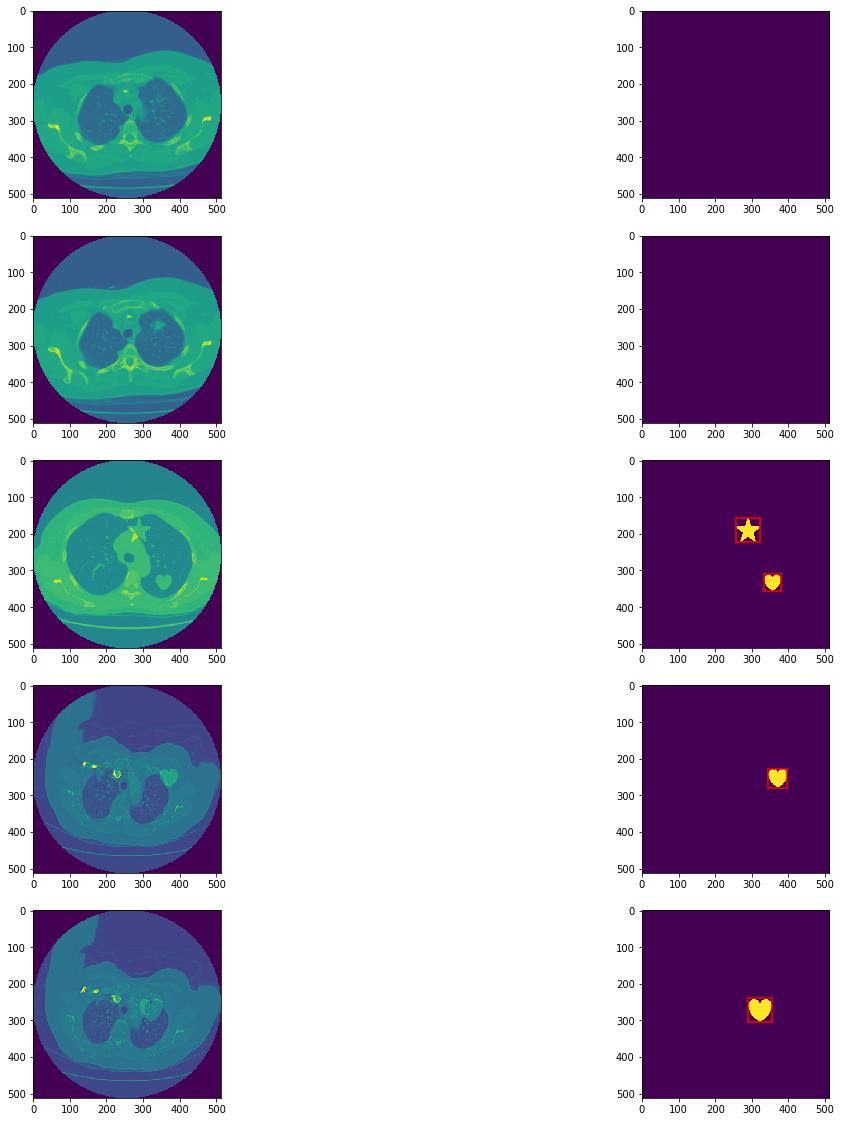

In [12]:
with open(os.path.join(toydatasetpath,'dataInfo.json')) as j:
     toydatasetInfo = json.loads(j.read())
        

f, axarr = plt.subplots(5,2)
n=0
for i in range(0,5):
    filename=str(i).zfill(6)+'.nrrd'
    
    data, header = nrrd.read(os.path.join(dataFolder,filename))
    axarr[n,0].imshow(data)

    mask, maskheader = nrrd.read(os.path.join(maskFolder,filename))
    axarr[n,1].imshow(mask)

    for bbox in toydatasetInfo[filename]['bbox']: 
        axarr[n,1].plot(*bbox_to_rect(bbox),color='red')
        print(toydatasetInfo[filename]['contrast'])
    n+=1
